In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'FLR'
yf_crypto = 'FLR'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [45]:
# Retreive max data
#data = yf.Ticker('ADA-USD')
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Create dataframe with 5 most recent years
crypto_df = crypto_df.tail(1825)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,0.025160,0.035060,0.025006,0.032053,18716200
2017-11-10,0.032219,0.033348,0.026451,0.027119,6766780
2017-11-11,0.026891,0.029659,0.025684,0.027437,5532220
2017-11-12,0.027480,0.027952,0.022591,0.023977,7280250
2017-11-13,0.024364,0.026300,0.023495,0.025808,4419440


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,0.457038,0.465180,0.453111,0.461485,309168258
2024-06-05,0.461485,0.464712,0.457757,0.461175,300839736
2024-06-06,0.461175,0.461865,0.452339,0.458102,281512944
2024-06-07,0.458100,0.488436,0.434423,0.449643,864294102
2024-06-08,0.449639,0.449639,0.433454,0.436571,384756660


In [6]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
#crypto_df = pd.read_csv(
#    f'~/crypto-forecast/resources/{crypto}-USD.csv',
#    index_col='Date',
#    parse_dates=True
#).dropna()

# Sort by ascending date
#crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
#display(crypto_df.head())
#display(crypto_df.tail())

In [7]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

0.43657100200653076

In [8]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.998240,0.997274,0.996889,0.675432
High,0.998240,1.000000,0.996508,0.998808,0.694447
Low,0.997274,0.996508,1.000000,0.997898,0.656381
Close,0.996889,0.998808,0.997898,1.000000,0.682680
Volume,0.675432,0.694447,0.656381,0.682680,1.000000


In [9]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [10]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2017-11-09,0.032053,18716200
2017-11-10,0.027119,6766780
2017-11-11,0.027437,5532220
2017-11-12,0.023977,7280250
2017-11-13,0.025808,4419440
...,...,...
2024-06-04,0.461485,309168258
2024-06-05,0.461175,300839736
2024-06-06,0.458102,281512944


In [11]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate volatility
df_close_ma.loc[:, 'Percent Change'] = df_close_ma['Close'].pct_change()*100
df_close_ma.loc[:, 'Volatility'] = df_close_ma['Percent Change'].rolling(10).std(ddof=0) * np.sqrt(252)

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [12]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2017-12-28,0.407701,82263800,0.437319,0.269667,0.175326
2017-12-29,0.529299,266403008,0.437121,0.284319,0.185270
2017-12-30,0.639243,645155968,0.452430,0.301631,0.197513
2017-12-31,0.719695,305947008,0.476615,0.321243,0.211358
2018-01-01,0.728657,150186000,0.508766,0.341120,0.225452


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,0.461485,309168258,0.454336,0.458540,0.462805
2024-06-05,0.461175,300839736,0.454616,0.458770,0.462857
2024-06-06,0.458102,281512944,0.453629,0.459311,0.463133
2024-06-07,0.449643,864294102,0.452895,0.459214,0.462963
2024-06-08,0.436571,384756660,0.451452,0.458316,0.462318


<Axes: xlabel='Date'>

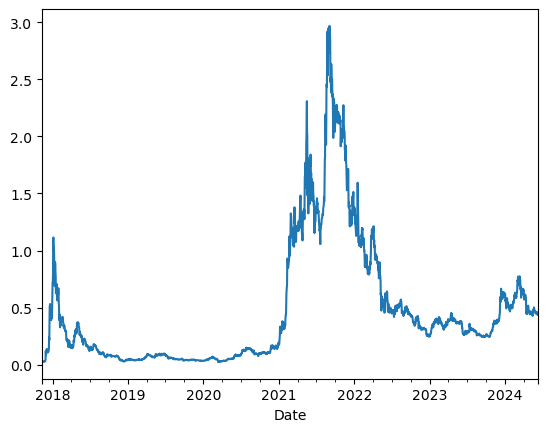

In [13]:
# Plot Close
df_close['Close'].plot()

In [14]:
## Create a Time Series Model with Prophet

In [15]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [16]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2017-11-09,0.032053,18716200
1,2017-11-10,0.027119,6766780
2,2017-11-11,0.027437,5532220
3,2017-11-12,0.023977,7280250
4,2017-11-13,0.025808,4419440
...,...,...,...
2399,2024-06-04,0.461485,309168258
2400,2024-06-05,0.461175,300839736
2401,2024-06-06,0.458102,281512944
2402,2024-06-07,0.449643,864294102


In [17]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [18]:
# Fit the time-series model.
crypto_model.fit(df_close)

16:10:21 - cmdstanpy - INFO - Chain [1] start processing
16:10:22 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2489,2024-09-02
2490,2024-09-03
2491,2024-09-04
2492,2024-09-05
2493,2024-09-06


In [20]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2489,2024-09-02,0.561618,0.449156,0.869859,0.513858,0.631207,0.095579,0.095579,0.095579,-0.000452,-0.000452,-0.000452,0.096032,0.096032,0.096032,0.0,0.0,0.0,0.657197
2490,2024-09-03,0.562103,0.440113,0.863988,0.512569,0.632679,0.090135,0.090135,0.090135,-0.002702,-0.002702,-0.002702,0.092837,0.092837,0.092837,0.0,0.0,0.0,0.652238
2491,2024-09-04,0.562589,0.434009,0.875225,0.512009,0.634151,0.088998,0.088998,0.088998,0.000042,0.000042,0.000042,0.088956,0.088956,0.088956,0.0,0.0,0.0,0.651587
2492,2024-09-05,0.563075,0.451683,0.862370,0.511449,0.636065,0.084022,0.084022,0.084022,-0.000463,-0.000463,-0.000463,0.084485,0.084485,0.084485,0.0,0.0,0.0,0.647096
2493,2024-09-06,0.563560,0.443411,0.854847,0.510299,0.637670,0.078246,0.078246,0.078246,-0.001279,-0.001279,-0.001279,0.079525,0.079525,0.079525,0.0,0.0,0.0,0.641806


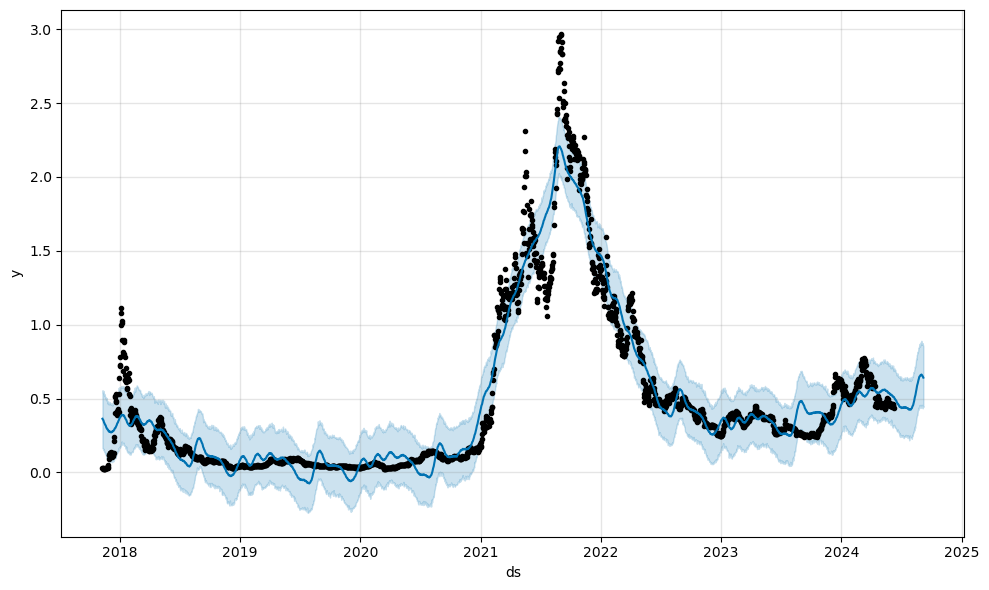

In [21]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [22]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [23]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,0.509334,0.323030,0.705139
2024-06-10,0.503200,0.316039,0.705045
2024-06-11,0.497767,0.305324,0.692249
2024-06-12,0.497128,0.306481,0.697000
2024-06-13,0.493055,0.302901,0.693569
...,...,...,...
2024-09-02,0.657197,0.449156,0.869859
2024-09-03,0.652238,0.440113,0.863988
2024-09-04,0.651587,0.434009,0.875225


In [24]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

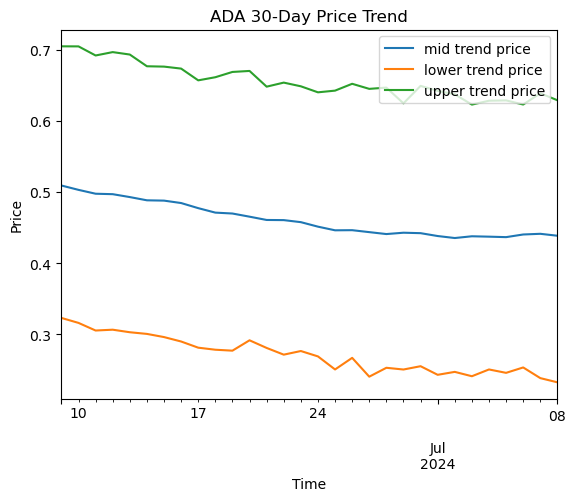

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

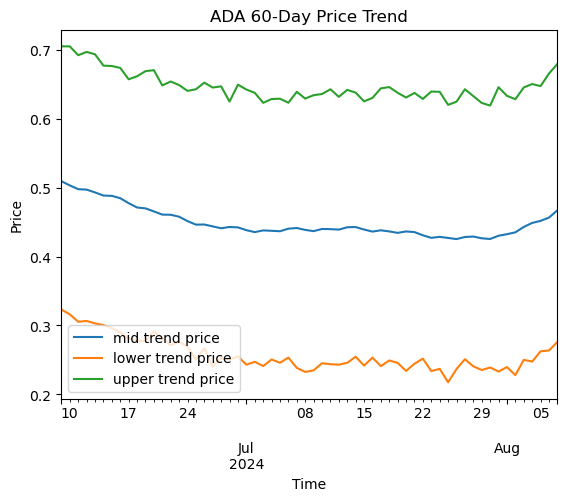

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

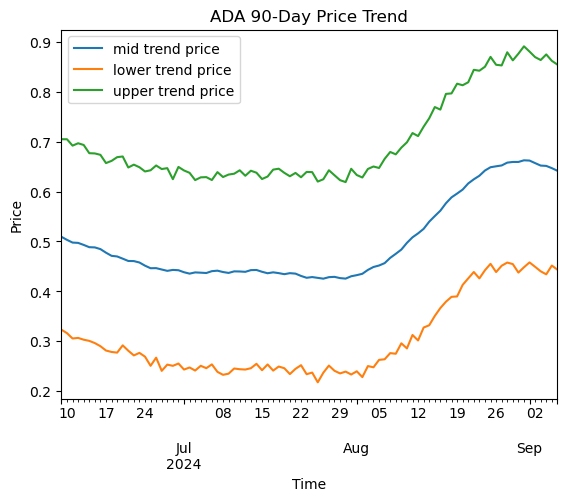

In [27]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend') 
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
#plt.savefig(f'/forecasts/{date}/{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [28]:
# Retrieve last closing price
last_close_price

0.43657100200653076

In [29]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

0.5093340840072178

In [30]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

0.4729525430068743

In [31]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

0.5112342991195077

In [32]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

0.4359113567851027

In [33]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

0.4750247287667516

In [34]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

0.6447351927466197

In [35]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.078

In [36]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

0.004

In [37]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.363

In [38]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

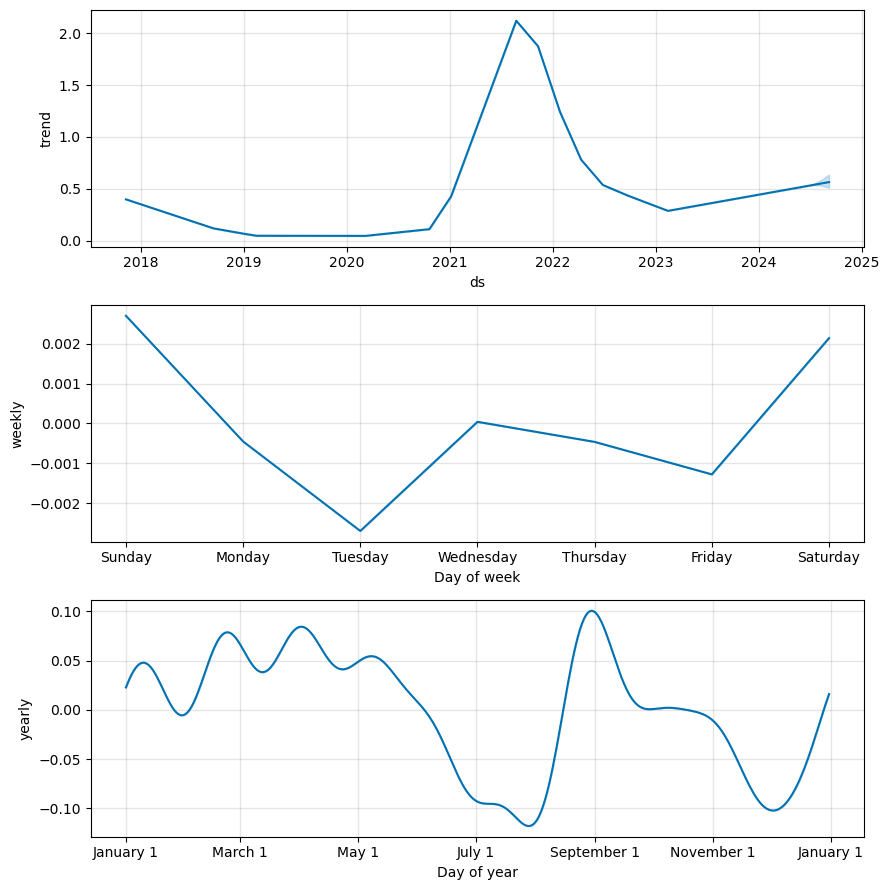

In [39]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

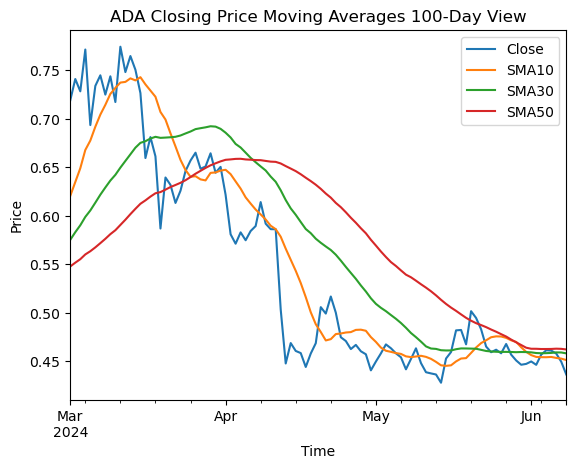

In [40]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

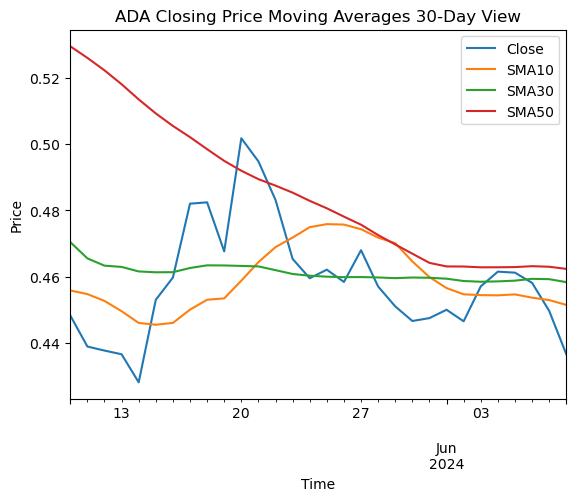

In [41]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [42]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [43]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [44]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335

